In [ ]:
!git clone https://github.com/ucsd-cse150a-ss25/notebooks.git

# Probability

This IPy notebook acts as supporting material for topics covered in **Chapter 13 Quantifying Uncertainty**, **Chapter 14 Probabilistic Reasoning**, **Chapter 15 Probabilistic Reasoning over Time**, **Chapter 16 Making Simple Decisions** and parts of **Chapter 25 Robotics** of the book* Artificial Intelligence: A Modern Approach*. This notebook makes use of the implementations in probability.py module. Let us import everything from the probability module. It might be helpful to view the source of some of our implementations. Please refer to the Introductory IPy file for more details on how to do so.

In [ ]:
from probability import *
from utils import print_table
from notebook import psource, pseudocode, heatmap

## CONTENTS

- Probability Distribution
    - Joint probability distribution
    - Inference using full joint distributions
<br>
- Bayesian Networks
    - BayesNode
    - BayesNet
    - Exact Inference in Bayesian Networks
        - Enumeration
        - Variable elimination
    - Approximate Inference in Bayesian Networks
        - Prior sample
        - Rejection sampling
        - Likelihood weighting
        - Gibbs sampling
<br>
- Hidden Markov Models
    - Inference in Hidden Markov Models
        - Forward-backward
        - Fixed lag smoothing
        - Particle filtering
<br>
<br>
- Monte Carlo Localization
- Decision Theoretic Agent
- Information Gathering Agent

## PROBABILITY DISTRIBUTION


Let us begin by specifying discrete probability distributions. The class **ProbDist** defines a discrete probability distribution. We name our random variable and then assign probabilities to the different values of the random variable. Assigning probabilities to the values works similar to that of using a dictionary with keys being the Value and we assign to it the probability. This is possible because of the magic methods **_ _getitem_ _**  and **_ _setitem_ _** which store the probabilities in the prob dict of the object. You can keep the source window open alongside while playing with the rest of the code to get a better understanding.

In [ ]:
psource(ProbDist)

In [ ]:
p = ProbDist('Flip')
p['H'], p['T'] = 0.25, 0.75
p['T']

0.75

The first parameter of the constructor **varname** has a default value of '?'. So if the name is not passed it defaults to ?. The keyword argument **freqs** can be a dictionary of values of random variable: probability. These are then normalized such that the probability values sum upto 1 using the **normalize** method.

In [ ]:
p = ProbDist(freqs={'low': 125, 'medium': 375, 'high': 500})
p.varname

'?'

In [ ]:
(p['low'], p['medium'], p['high'])

(0.125, 0.375, 0.5)

Besides the **prob** and **varname** the object also separately keeps track of all the values of the distribution in a list called **values**. Every time a new value is assigned a probability it is appended to this list, This is done inside the **_ _setitem_ _** method.

In [ ]:
p.values

['low', 'medium', 'high']

The distribution by default is not normalized if values are added incrementally. We can still force normalization by invoking the **normalize** method.

In [ ]:
p = ProbDist('Y')
p['Cat'] = 50
p['Dog'] = 114
p['Mice'] = 64
(p['Cat'], p['Dog'], p['Mice'])

(50, 114, 64)

In [ ]:
p.normalize()
(p['Cat'], p['Dog'], p['Mice'])

(0.21929824561403508, 0.5, 0.2807017543859649)

It is also possible to display the approximate values upto decimals using the **show_approx** method.

In [ ]:
p.show_approx()

'Cat: 0.219, Dog: 0.5, Mice: 0.281'

## Joint Probability Distribution

The helper function **event_values** returns a tuple of the values of variables in event. An event is specified by a dict where the keys are the names of variables and the corresponding values are the value of the variable. Variables are specified with a list. The ordering of the returned tuple is same as those of the variables.


Alternatively if the event is specified by a list or tuple of equal length of the variables. Then the events tuple is returned as it is.

In [ ]:
event = {'A': 10, 'B': 9, 'C': 8}
variables = ['C', 'A']
event_values(event, variables)

(8, 10)

_A probability model is completely determined by the joint distribution for all of the random variables._ (**Section 13.3**) The probability module implements these as the class **JointProbDist** which inherits from the **ProbDist** class. This class specifies a discrete probability distribute over a set of variables.

In [ ]:
psource(JointProbDist)

Values for a Joint Distribution is a an ordered tuple in which each item corresponds to the value associate with a particular variable. For Joint Distribution of X, Y where X, Y take integer values this can be something like (18, 19).

To specify a Joint distribution we first need an ordered list of variables.

In [ ]:
variables = ['X', 'Y']
j = JointProbDist(variables)
j

P(['X', 'Y'])

Like the **ProbDist** class **JointProbDist** also employes magic methods to assign probability to different values.
The probability can be assigned in either of the two formats for all possible values of the distribution. The **event_values** call inside  **_ _getitem_ _**  and **_ _setitem_ _** does the required processing to make this work.

In [ ]:
j[1,1] = 0.2
j[dict(X=0, Y=1)] = 0.5

(j[1,1], j[0,1])

(0.2, 0.5)

It is also possible to list all the values for a particular variable using the **values** method.

In [ ]:
j.values('X')

[1, 0]

## Inference Using Full Joint Distributions

In this section we use Full Joint Distributions to calculate the posterior distribution given some evidence. We represent evidence by using a python dictionary with variables as dict keys and dict values representing the values.

This is illustrated in **Section 13.3** of the book. The functions **enumerate_joint** and **enumerate_joint_ask** implement this functionality. Under the hood they implement **Equation 13.9** from the book.

$$\textbf{P}(X | \textbf{e}) = \alpha \textbf{P}(X, \textbf{e}) = \alpha \sum_{y} \textbf{P}(X, \textbf{e}, \textbf{y})$$

Here **α** is the normalizing factor. **X** is our query variable and **e** is the evidence. According to the equation we enumerate on the remaining variables **y** (not in evidence or query variable) i.e. all possible combinations of **y**

We will be using the same example as the book. Let us create the full joint distribution from **Figure 13.3**.

In [ ]:
full_joint = JointProbDist(['Cavity', 'Toothache', 'Catch'])
full_joint[dict(Cavity=True, Toothache=True, Catch=True)] = 0.108
full_joint[dict(Cavity=True, Toothache=True, Catch=False)] = 0.012
full_joint[dict(Cavity=True, Toothache=False, Catch=True)] = 0.016
full_joint[dict(Cavity=True, Toothache=False, Catch=False)] = 0.064
full_joint[dict(Cavity=False, Toothache=True, Catch=True)] = 0.072
full_joint[dict(Cavity=False, Toothache=False, Catch=True)] = 0.144
full_joint[dict(Cavity=False, Toothache=True, Catch=False)] = 0.008
full_joint[dict(Cavity=False, Toothache=False, Catch=False)] = 0.576

Let us now look at the **enumerate_joint** function returns the sum of those entries in P consistent with e,provided variables is P's remaining variables (the ones not in e). Here, P refers to the full joint distribution. The function uses a recursive call in its implementation. The first parameter **variables** refers to remaining variables. The function in each recursive call keeps on variable constant while varying others.

In [ ]:
psource(enumerate_joint)

Let us assume we want to find **P(Toothache=True)**. This can be obtained by marginalization (**Equation 13.6**). We can use **enumerate_joint** to solve for this by taking Toothache=True as our evidence. **enumerate_joint** will return the sum of probabilities consistent with evidence i.e. Marginal Probability.

In [ ]:
evidence = dict(Toothache=True)
variables = ['Cavity', 'Catch'] # variables not part of evidence
ans1 = enumerate_joint(variables, evidence, full_joint)
ans1

0.19999999999999998

You can verify the result from our definition of the full joint distribution. We can use the same function to find more complex probabilities like **P(Cavity=True and Toothache=True)**

In [ ]:
evidence = dict(Cavity=True, Toothache=True)
variables = ['Catch'] # variables not part of evidence
ans2 = enumerate_joint(variables, evidence, full_joint)
ans2

0.12

Being able to find sum of probabilities satisfying given evidence allows us to compute conditional probabilities like **P(Cavity=True | Toothache=True)** as we can rewrite this as $$P(Cavity=True | Toothache = True) = \frac{P(Cavity=True \ and \ Toothache=True)}{P(Toothache=True)}$$

We have already calculated both the numerator and denominator.

In [ ]:
ans2/ans1

0.6

We might be interested in the probability distribution of a particular variable conditioned on some evidence. This can involve doing calculations like above for each possible value of the variable. This has been implemented slightly differently  using normalization in the function **enumerate_joint_ask** which returns a probability distribution over the values of the variable **X**, given the {var:val} observations **e**, in the **JointProbDist P**. The implementation of this function calls **enumerate_joint** for each value of the query variable and passes **extended evidence** with the new evidence having **X = x<sub>i</sub>**. This is followed by normalization of the obtained distribution.

In [ ]:
psource(enumerate_joint_ask)

Let us find **P(Cavity | Toothache=True)** using **enumerate_joint_ask**.

In [ ]:
query_variable = 'Cavity'
evidence = dict(Toothache=True)
ans = enumerate_joint_ask(query_variable, evidence, full_joint)
(ans[True], ans[False])

(0.6, 0.39999999999999997)

You can verify that the first value is the same as we obtained earlier by manual calculation.

## BAYESIAN NETWORKS

A Bayesian network is a representation of the joint probability distribution encoding a collection of conditional independence statements.

A Bayes Network is implemented as the class **BayesNet**. It consisits of a collection of nodes implemented by the class **BayesNode**. The implementation in the above mentioned classes focuses only on boolean variables. Each node is associated with a variable and it contains a **conditional probabilty table (cpt)**. The **cpt** represents the probability distribution of the variable conditioned on its parents **P(X | parents)**.

Let us dive into the **BayesNode** implementation.

In [ ]:
psource(BayesNode)

The constructor takes in the name of **variable**, **parents** and **cpt**. Here **variable** is a the name of the variable like 'Earthquake'. **parents** should a list or space separate string with variable names of parents. The conditional probability table is a dict {(v1, v2, ...): p, ...}, the distribution P(X=true | parent1=v1, parent2=v2, ...) = p. Here the keys are combination of boolean values that the parents take. The length and order of the values in keys should be same as the supplied **parent** list/string. In all cases the probability of X being false is left implicit, since it follows from P(X=true).

The example below where we implement the network shown in **Figure 14.3** of the book will make this more clear.

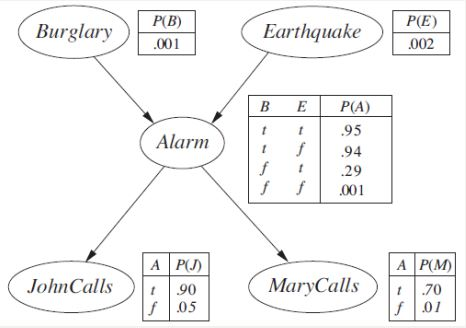

The alarm node can be made as follows:

In [ ]:
alarm_node = BayesNode('Alarm', ['Burglary', 'Earthquake'],
                       {(True, True): 0.95,(True, False): 0.94, (False, True): 0.29, (False, False): 0.001})

It is possible to avoid using a tuple when there is only a single parent. So an alternative format for the **cpt** is

In [ ]:
john_node = BayesNode('JohnCalls', ['Alarm'], {True: 0.90, False: 0.05})
mary_node = BayesNode('MaryCalls', 'Alarm', {(True, ): 0.70, (False, ): 0.01}) # Using string for parents.
# Equivalant to john_node definition.

The general format used for the alarm node always holds. For nodes with no parents we can also use.

In [ ]:
burglary_node = BayesNode('Burglary', '', 0.001)
earthquake_node = BayesNode('Earthquake', '', 0.002)

It is possible to use the node for lookup function using the **p** method. The method takes in two arguments **value** and **event**. Event must be a dict of the type {variable:values, ..} The value corresponds to the value of the variable we are interested in (False or True).The method returns the conditional probability **P(X=value | parents=parent_values)**, where parent_values are the values of parents in event. (event must assign each parent a value.)

In [ ]:
john_node.p(False, {'Alarm': True, 'Burglary': True}) # P(JohnCalls=False | Alarm=True)

0.09999999999999998

With all the information about nodes present it is possible to construct a Bayes Network using **BayesNet**. The **BayesNet** class does not take in nodes as input but instead takes a list of **node_specs**. An entry in **node_specs** is a tuple of the parameters we use to construct a **BayesNode** namely **(X, parents, cpt)**. **node_specs** must be ordered with parents before children.

In [ ]:
psource(BayesNet)

The constructor of **BayesNet** takes each item in **node_specs** and adds a **BayesNode** to its **nodes** object variable by calling the **add** method. **add** in turn adds  node to the net. Its parents must already be in the net, and its variable must not. Thus add allows us to grow a **BayesNet** given its parents are already present.

**burglary** global is an instance of **BayesNet** corresponding to the above example.

    T, F = True, False

    burglary = BayesNet([
        ('Burglary', '', 0.001),
        ('Earthquake', '', 0.002),
        ('Alarm', 'Burglary Earthquake',
         {(T, T): 0.95, (T, F): 0.94, (F, T): 0.29, (F, F): 0.001}),
        ('JohnCalls', 'Alarm', {T: 0.90, F: 0.05}),
        ('MaryCalls', 'Alarm', {T: 0.70, F: 0.01})
    ])

In [ ]:
burglary

BayesNet([('Burglary', ''), ('Earthquake', ''), ('Alarm', 'Burglary Earthquake'), ('JohnCalls', 'Alarm'), ('MaryCalls', 'Alarm')])

**BayesNet** method **variable_node** allows to reach **BayesNode** instances inside a Bayes Net. It is possible to modify the **cpt** of the nodes directly using this method.

In [ ]:
type(burglary.variable_node('Alarm'))

probability.BayesNode

In [ ]:
burglary.variable_node('Alarm').cpt

{(True, True): 0.95,
 (True, False): 0.94,
 (False, True): 0.29,
 (False, False): 0.001}

### Likelihood Weighting

Rejection sampling takes a long time to run when the probability of finding consistent evidence is low. It is also slow for larger networks and more evidence variables.
Rejection sampling tends to reject a lot of samples if our evidence consists of a large number of variables. Likelihood Weighting solves this by fixing the evidence (i.e. not sampling it) and then using weights to make sure that our overall sampling is still consistent.

The pseudocode in **Figure 14.15** is implemented as **likelihood_weighting** and **weighted_sample**.

In [ ]:
psource(weighted_sample)


**weighted_sample** samples an event from Bayesian Network that's consistent with the evidence **e** and returns the event and its weight, the likelihood that the event accords to the evidence. It takes in two parameters **bn** the Bayesian Network and **e** the evidence.

The weight is obtained by multiplying **P(x<sub>i</sub> | parents(x<sub>i</sub>))** for each node in evidence. We set the values of **event = evidence** at the start of the function.

In [ ]:
weighted_sample(sprinkler, dict(Rain=True))

({'Rain': True, 'Cloudy': False, 'Sprinkler': True, 'WetGrass': True}, 0.2)

In [ ]:
psource(likelihood_weighting)

**likelihood_weighting** implements the algorithm to solve our inference problem. The code is similar to **rejection_sampling** but instead of adding one for each sample we add the weight obtained from **weighted_sampling**.

In [ ]:
likelihood_weighting('Cloudy', dict(Rain=True), sprinkler, 200).show_approx()

'False: 0.2, True: 0.8'

## Exact Inference in Bayesian Networks


A Bayes Network is a more compact representation of the full joint distribution and like full joint distributions allows us to do inference i.e. answer questions about probability distributions of random variables given some evidence.

Exact algorithms don't scale well for larger networks. Approximate algorithms are explained in the next section.

### Inference by Enumeration

We apply techniques similar to those used for **enumerate_joint_ask** and **enumerate_joint** to draw inference from Bayesian Networks. **enumeration_ask** and **enumerate_all** implement the algorithm described in **Figure 14.9** of the book.

In [ ]:
psource(enumerate_all)

**enumerate_all** recursively evaluates a general form of the **Equation 14.4** in the book.

$$\textbf{P}(X | \textbf{e}) = α \textbf{P}(X, \textbf{e}) = α \sum_{y} \textbf{P}(X, \textbf{e}, \textbf{y})$$

such that **P(X, e, y)** is written in the form of product of conditional probabilities **P(variable | parents(variable))** from the Bayesian Network.

**enumeration_ask** calls **enumerate_all** on each value of query variable **X** and finally normalizes them.


In [ ]:
psource(enumeration_ask)

Let us solve the problem of finding out **P(Burglary=True | JohnCalls=True, MaryCalls=True)** using the **burglary** network. **enumeration_ask** takes three arguments **X** = variable name, **e** = Evidence (in form a dict like previously explained), **bn** = The Bayes Net to do inference on.

In [ ]:
ans_dist = enumeration_ask('Burglary', {'JohnCalls': True, 'MaryCalls': True}, burglary)
ans_dist[True]

0.2841718353643929

### Variable Elimination

The enumeration algorithm can be improved substantially by eliminating repeated calculations. In enumeration we join the joint of all hidden variables. This is of exponential size for the number of hidden variables. Variable elimination employes interleaving join and marginalization.

Before we look into the implementation of Variable Elimination we must first familiarize ourselves with Factors.

In general we call a multidimensional array of type P(Y1 ... Yn | X1 ... Xm) a factor where some of Xs and Ys maybe assigned values. Factors are implemented in the probability module as the class **Factor**. They take as input **variables** and **cpt**.


#### Helper Functions

There are certain helper functions that help creating the **cpt** for the Factor given the evidence. Let us explore them one by one.

In [ ]:
psource(make_factor)

**make_factor** is used to create the **cpt** and **variables** that will be passed to the constructor of **Factor**. We use **make_factor** for each variable. It takes in the arguments **var** the particular variable, **e** the evidence we want to do inference on, **bn** the bayes network.

Here **variables** for each node refers to a list consisting of the variable itself and the parents minus any variables that are part of the evidence. This is created by finding the **node.parents** and filtering out those that are not part of the evidence.

The **cpt** created is the one similar to the original **cpt** of the node with only rows that agree with the evidence.

In [ ]:
psource(all_events)

The **all_events** function is a recursive generator function which yields a key for the orignal **cpt** which is part of the node. This works by extending evidence related to the node, thus all the output from **all_events** only includes events that support the evidence. Given **all_events** is a generator function one such event is returned on every call.

We can try this out using the example on **Page 524** of the book. We will make **f**<sub>5</sub>(A) = P(m | A)

In [ ]:
f5 = make_factor('MaryCalls', {'JohnCalls': True, 'MaryCalls': True}, burglary)

In [ ]:
f5

In [ ]:
f5.cpt

{(True,): 0.7, (False,): 0.01}

In [ ]:
f5.variables

['Alarm']

Here **f5.cpt** False key gives probability for **P(MaryCalls=True | Alarm = False)**. Due to our representation where we only store probabilities for only in cases where the node variable is True this is the same as the **cpt** of the BayesNode. Let us try a somewhat different example from the book where evidence is that the Alarm = True

In [ ]:
new_factor = make_factor('MaryCalls', {'Alarm': True}, burglary)

In [ ]:
new_factor.cpt

{(True,): 0.7, (False,): 0.30000000000000004}

Here the **cpt** is for **P(MaryCalls | Alarm = True)**. Therefore the probabilities for True and False sum up to one. Note the difference between both the cases. Again the only rows included are those consistent with the evidence.

#### Operations on Factors

We are interested in two kinds of operations on factors. **Pointwise Product** which is used to created joint distributions and **Summing Out** which is used for marginalization.

In [ ]:
psource(Factor.pointwise_product)

**Factor.pointwise_product** implements a method of creating a joint via combining two factors. We take the union of **variables** of both the factors and then generate the **cpt** for the new factor using **all_events** function. Note that the given we have eliminated rows that are not consistent with the evidence. Pointwise product assigns new probabilities by multiplying rows similar to that in a database join.

In [ ]:
psource(pointwise_product)

**pointwise_product** extends this operation to more than two operands where it is done sequentially in pairs of two.

In [ ]:
psource(Factor.sum_out)

**Factor.sum_out** makes a factor eliminating a variable by summing over its values. Again **events_all** is used to generate combinations for the rest of the variables.

In [ ]:
psource(sum_out)

**sum_out** uses both **Factor.sum_out** and **pointwise_product** to finally eliminate a particular variable from all factors by summing over its values.

#### Elimination Ask

The algorithm described in **Figure 14.11** of the book is implemented by the function **elimination_ask**. We use this for inference. The key idea is that we eliminate the hidden variables by interleaving joining and marginalization. It takes in 3 arguments **X** the query variable, **e** the evidence variable and **bn** the Bayes network.

The algorithm creates factors out of Bayes Nodes in reverse order and eliminates hidden variables using **sum_out**. Finally it takes a point wise product of all factors and normalizes. Let us finally solve the problem of inferring

**P(Burglary=True | JohnCalls=True, MaryCalls=True)** using variable elimination.

In [ ]:
psource(elimination_ask)

In [ ]:
elimination_ask('Burglary', dict(JohnCalls=True, MaryCalls=True), burglary).show_approx()

'False: 0.716, True: 0.284'

#### Elimination Ask Optimizations

`elimination_ask` has some critical point to consider and some optimizations could be performed:

- **Operation on factors**:

  `sum_out` and `pointwise_product` function used in `elimination_ask` is where space and time complexity arise in the variable elimination algorithm (AIMA3e pg. 526).

>The only trick is to notice that any factor that does not depend on the variable to be summed out can be moved outside the summation.

- **Variable ordering**:

  Elimination ordering is important, every choice of ordering yields a valid algorithm, but different orderings cause different intermediate factors to be generated during the calculation (AIMA3e pg. 527). In this case the algorithm applies a reversed order.

> In general, the time and space requirements of variable elimination are dominated by the size of the largest factor constructed during the operation of the algorithm. This in turn is determined by the order of elimination of variables and by the structure of the network. It turns out to be intractable to determine the optimal ordering, but several good heuristics are available. One fairly effective method is a greedy one: eliminate whichever variable minimizes the size of the next factor to be constructed.  

- **Variable relevance**
  
  Some variables could be irrelevant to resolve a query  (i.e. sums to 1). A variable elimination algorithm can therefore remove all these variables before evaluating the query (AIMA3e pg. 528).

> An optimization is to remove 'every variable that is not an ancestor of a query variable or evidence variable is irrelevant to the query'.

#### Runtime comparison
Let's see how the runtimes of these two algorithms compare.
We expect variable elimination to outperform enumeration by a large margin as we reduce the number of repetitive calculations significantly.

In [ ]:
%%timeit
enumeration_ask('Burglary', dict(JohnCalls=True, MaryCalls=True), burglary).show_approx()

105 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%%timeit
elimination_ask('Burglary', dict(JohnCalls=True, MaryCalls=True), burglary).show_approx()

262 µs ± 54.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In this test case we observe that variable elimination is slower than what we expected. It has something to do with number of threads, how Python tries to optimize things and  this happens because the network is very small, with just 5 nodes. The `elimination_ask` has some critical point and some optimizations must be perfomed as seen above.
<br>
Of course, for more complicated networks, variable elimination will be significantly faster and runtime will drop not just by a constant factor, but by a polynomial factor proportional to the number of nodes, due to the reduction in repeated calculations.

## Approximate Inference in Bayesian Networks

Exact inference fails to scale for very large and complex Bayesian Networks. This section covers implementation of randomized sampling algorithms, also called Monte Carlo algorithms.

In [ ]:
psource(BayesNode.sample)

Before we consider the different algorithms in this section let us look at the **BayesNode.sample** method. It samples from the distribution for this variable conditioned on event's values for parent_variables. That is, return True/False at random according to with the conditional probability given the parents. The **probability** function is a simple helper from **utils** module which returns True with the probability passed to it.

### Prior Sampling

The idea of Prior Sampling is to sample from the Bayesian Network in a topological order. We start at the top of the network and sample as per **P(X<sub>i</sub> | parents(X<sub>i</sub>)** i.e. the probability distribution from which the value is sampled is conditioned on the values already assigned to the variable's parents. This can be thought of as a simulation.

In [ ]:
psource(prior_sample)

The function **prior_sample** implements the algorithm described in **Figure 14.13** of the book. Nodes are sampled in the topological order. The old value of the event is passed as evidence for parent values. We will use the Bayesian Network in **Figure 14.12** to try out the **prior_sample**

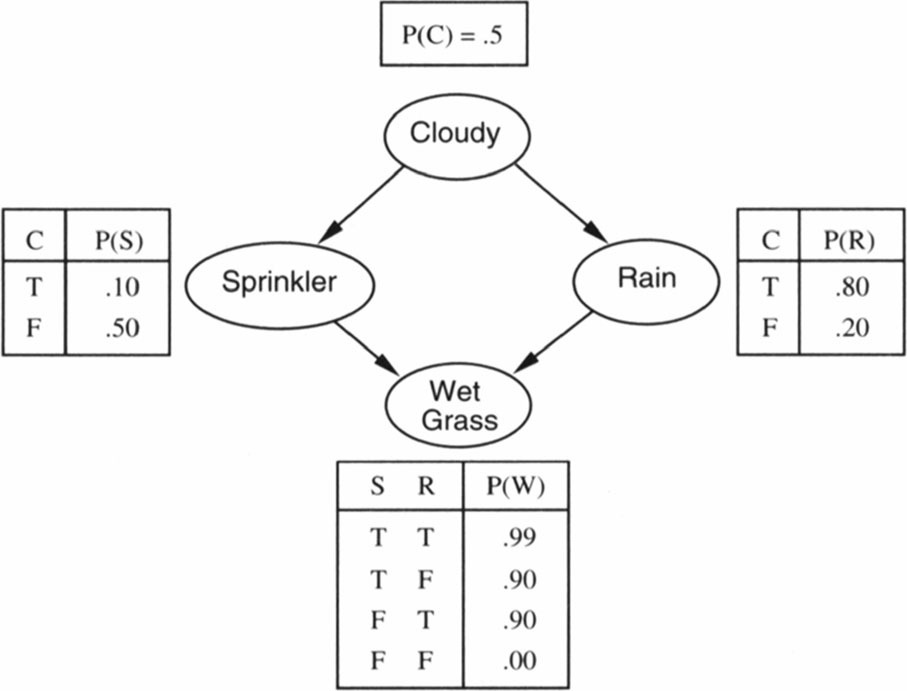

Traversing the graph in topological order is important.
There are two possible topological orderings for this particular directed acyclic graph.
<br>
1. `Cloudy -> Sprinkler -> Rain -> Wet Grass`
2. `Cloudy -> Rain -> Sprinkler -> Wet Grass`
<br>
<br>
We can follow any of the two orderings to sample from the network.
Any ordering other than these two, however, cannot be used.
<br>
One way to think about this is that `Cloudy` can be seen as a precondition of both `Rain` and `Sprinkler` and just like we have seen in planning, preconditions need to be satisfied before a certain action can be executed.
<br>
We store the samples on the observations. Let us find **P(Rain=True)** by taking 1000 random samples from the network.

In [ ]:
N = 1000
all_observations = [prior_sample(sprinkler) for x in range(N)]

Now we filter to get the observations where Rain = True

In [ ]:
rain_true = [observation for observation in all_observations if observation['Rain'] == True]

Finally, we can find **P(Rain=True)**

In [ ]:
answer = len(rain_true) / N
print(answer)

0.503


Sampling this another time might give different results as we have no control over the distribution of the random samples

In [ ]:
N = 1000
all_observations = [prior_sample(sprinkler) for x in range(N)]
rain_true = [observation for observation in all_observations if observation['Rain'] == True]
answer = len(rain_true) / N
print(answer)

0.519


To evaluate a conditional distribution. We can use a two-step filtering process. We first separate out the variables that are consistent with the evidence. Then for each value of query variable, we can find probabilities. For example to find **P(Cloudy=True | Rain=True)**. We have already filtered out the values consistent with our evidence in **rain_true**. Now we apply a second filtering step on **rain_true** to find **P(Rain=True and Cloudy=True)**

In [ ]:
rain_and_cloudy = [observation for observation in rain_true if observation['Cloudy'] == True]
answer = len(rain_and_cloudy) / len(rain_true)
print(answer)

0.8265895953757225


### Rejection Sampling

Rejection Sampling is based on an idea similar to what we did just now.
First, it generates samples from the prior distribution specified by the network.
Then, it rejects all those that do not match the evidence.
<br>
Rejection sampling is advantageous only when we know the query beforehand.
While prior sampling generally works for any query, it might fail in some scenarios.
<br>
Let's say we have a generic Bayesian network and we have evidence `e`, and we want to know how many times a state `A` is true, given evidence `e` is true.
Normally, prior sampling can answer this question, but let's assume that the probability of evidence `e` being true in our actual probability distribution is very small.
In this situation, it might be possible that sampling never encounters a data-point where `e` is true.
If our sampled data has no instance of `e` being true, `P(e) = 0`, and therefore `P(A | e) / P(e) = 0/0`, which is undefined.
We cannot find the required value using this sample.
<br>
We can definitely increase the number of sample points, but we can never guarantee that we will encounter the case where `e` is non-zero (assuming our actual probability distribution has atleast one case where `e` is true).
To guarantee this, we would have to consider every single data point, which means we lose the speed advantage that approximation provides us and we essentially have to calculate the exact inference model of the Bayesian network.
<br>
<br>
Rejection sampling will be useful in this situation, as we already know the query.
<br>
While sampling from the network, we will reject any sample which is inconsistent with the evidence variables of the given query (in this example, the only evidence variable is `e`).
We will only consider samples that do not violate **any** of the evidence variables.
In this way, we will have enough data with the required evidence to infer queries involving a subset of that evidence.
<br>
<br>
The function **rejection_sampling** implements the algorithm described by **Figure 14.14**

In [ ]:
psource(rejection_sampling)

The function keeps counts of each of the possible values of the Query variable and increases the count when we see an observation consistent with the evidence. It takes in input parameters **X** - The Query Variable, **e** - evidence, **bn** - Bayes net and **N** - number of prior samples to generate.

**consistent_with** is used to check consistency.

In [ ]:
psource(consistent_with)

To answer **P(Cloudy=True | Rain=True)**

In [ ]:
p = rejection_sampling('Cloudy', dict(Rain=True), sprinkler, 1000)
p[True]

0.8035019455252919

### Likelihood Weighting

Rejection sampling takes a long time to run when the probability of finding consistent evidence is low. It is also slow for larger networks and more evidence variables.
Rejection sampling tends to reject a lot of samples if our evidence consists of a large number of variables. Likelihood Weighting solves this by fixing the evidence (i.e. not sampling it) and then using weights to make sure that our overall sampling is still consistent.

The pseudocode in **Figure 14.15** is implemented as **likelihood_weighting** and **weighted_sample**.

In [ ]:
psource(weighted_sample)


**weighted_sample** samples an event from Bayesian Network that's consistent with the evidence **e** and returns the event and its weight, the likelihood that the event accords to the evidence. It takes in two parameters **bn** the Bayesian Network and **e** the evidence.

The weight is obtained by multiplying **P(x<sub>i</sub> | parents(x<sub>i</sub>))** for each node in evidence. We set the values of **event = evidence** at the start of the function.

In [ ]:
weighted_sample(sprinkler, dict(Rain=True))

({'Rain': True, 'Cloudy': False, 'Sprinkler': True, 'WetGrass': True}, 0.2)

In [ ]:
psource(likelihood_weighting)

**likelihood_weighting** implements the algorithm to solve our inference problem. The code is similar to **rejection_sampling** but instead of adding one for each sample we add the weight obtained from **weighted_sampling**.

In [ ]:
likelihood_weighting('Cloudy', dict(Rain=True), sprinkler, 200).show_approx()

'False: 0.2, True: 0.8'

### Gibbs Sampling

In likelihood sampling, it is possible to obtain low weights in cases where the evidence variables reside at the bottom of the Bayesian Network. This can happen because influence only propagates downwards in likelihood sampling.

Gibbs Sampling solves this. The implementation of **Figure 14.16** is provided in the function **gibbs_ask**

In [ ]:
psource(gibbs_ask)

In **gibbs_ask** we initialize the non-evidence variables to random values. And then select non-evidence variables and sample it from **P(Variable | value in the current state of all remaining vars) ** repeatedly sample. In practice, we speed this up by using **markov_blanket_sample** instead. This works because terms not involving the variable get canceled in the calculation. The arguments for **gibbs_ask** are similar to **likelihood_weighting**

In [ ]:
gibbs_ask('Cloudy', dict(Rain=True), sprinkler, 200).show_approx()

'False: 0.215, True: 0.785'

#### Runtime analysis
Let's take a look at how much time each algorithm takes.

In [ ]:
%%timeit
all_observations = [prior_sample(sprinkler) for x in range(1000)]
rain_true = [observation for observation in all_observations if observation['Rain'] == True]
len([observation for observation in rain_true if observation['Cloudy'] == True]) / len(rain_true)

13.2 ms ± 3.45 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
rejection_sampling('Cloudy', dict(Rain=True), sprinkler, 1000)

11 ms ± 687 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
likelihood_weighting('Cloudy', dict(Rain=True), sprinkler, 200)

2.12 ms ± 554 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
gibbs_ask('Cloudy', dict(Rain=True), sprinkler, 200)

14.4 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


As expected, all algorithms have a very similar runtime.
However, rejection sampling would be a lot faster and more accurate when the probabiliy of finding data-points consistent with the required evidence is small.
<br>
Likelihood weighting is the fastest out of all as it doesn't involve rejecting samples, but also has a quite high variance.

## HIDDEN MARKOV MODELS

Often, we need to carry out probabilistic inference on temporal data or a sequence of observations where the order of observations matter.
We require a model similar to a Bayesian Network, but one that grows over time to keep up with the latest evidences.
If you are familiar with the `mdp` module or Markov models in general, you can probably guess that a Markov model might come close to representing our problem accurately.
<br>
A Markov model is basically a chain-structured Bayesian Network in which there is one state for each time step and each node has an identical probability distribution.
The first node, however, has a different distribution, called the prior distribution which models the initial state of the process.
A state in a Markov model depends only on the previous state and the latest evidence and not on the states before it.
<br>
A **Hidden Markov Model** or **HMM** is a special case of a Markov model in which the state of the process is described by a single discrete random variable.
The possible values of the variable are the possible states of the world.
<br>
But what if we want to model a process with two or more state variables?
In that case, we can still fit the process into the HMM framework by redefining our state variables as a single "megavariable".
We do this because carrying out inference on HMMs have standard optimized algorithms.
A HMM is very similar to an MDP, but we don't have the option of taking actions like in MDPs, instead, the process carries on as new evidence appears.
<br>
If a HMM is truncated at a fixed length, it becomes a Bayesian network and general BN inference can be used on it to answer queries.

Before we start, it will be helpful to understand the structure of a temporal model. We will use the example of the book with the guard and the umbrella. In this example, the state $\textbf{X}$ is whether it is a rainy day (`X = True`) or not (`X = False`) at Day $\textbf{t}$. In the sensor or observation model, the observation or evidence $\textbf{U}$ is whether the professor holds an umbrella (`U = True`) or not (`U = False`) on **Day** $\textbf{t}$. Based on that, the transition model is

| $X_{t-1}$         | $X_{t}$         | **P**$(X_{t}| X_{t-1})$|  
| -------------     |-------------    | ----------------------------------|
| ***${False}$***  | ***${False}$***  | 0.7                         |
| ***${False}$***  | ***${True}$***   | 0.3                         |
| ***${True}$***   | ***${False}$***  | 0.3                         |
| ***${True}$***   | ***${True}$***   | 0.7                         |

And the the sensor model will be,

| $X_{t}$          | $U_{t}$         | **P**$(U_{t}|X_{t})$|  
| :-------------:  |:-------------:  | :------------------------:|
| ***${False}$***  | ***${True}$***  | 0.2     |
| ***${False}$***  | ***${False}$*** | 0.8     |
| ***${True}$***   | ***${True}$***  | 0.9     |
| ***${True}$***   | ***${False}$*** | 0.1     |


HMMs are implemented in the **`HiddenMarkovModel`** class.
Let's have a look.

In [ ]:
class HiddenMarkovModel:
    """A Hidden markov model which takes Transition model and Sensor model as inputs"""
    def __init__(self, transition_model, sensor_model, prior=None):
        self.transition_model = transition_model
        self.sensor_model = sensor_model
        self.prior = prior or [0.5, 0.5]

    def sensor_dist(self, ev):
        if ev is True:
            return self.sensor_model[0]
        else:
            return self.sensor_model[1]

We instantiate the object **`hmm`** of the class using a list of lists for both the transition and the sensor model.

In [ ]:
umbrella_transition_model = [[0.7, 0.3], [0.3, 0.7]]
umbrella_sensor_model = [[0.9, 0.2], [0.1, 0.8]]
hmm = HiddenMarkovModel(umbrella_transition_model, umbrella_sensor_model)

The **`sensor_dist()`** method returns a list with the conditional probabilities of the sensor model.

In [ ]:
hmm.sensor_dist(ev=True)

[0.9, 0.2]

Now that we have defined an HMM object, our task here is to compute the belief $B_{t}(x)= P(X_{t}|U_{1:t})$ given evidence **U** at each time step **t**.
<br>
The basic inference tasks that must be solved are:
1. **Filtering**: Computing the posterior probability distribution over the most recent state, given all the evidence up to the current time step.
2. **Prediction**: Computing the posterior probability distribution over the future state.
3. **Smoothing**: Computing the posterior probability distribution over a past state. Smoothing provides a better estimation as it incorporates more evidence.
4. **Most likely explanation**: Finding the most likely sequence of states for a given observation
5. **Learning**: The transition and sensor models can be learnt, if not yet known, just like in an information gathering agent
<br>
<br>

There are three primary methods to carry out inference in Hidden Markov Models:
1. The Forward-Backward algorithm
2. Fixed lag smoothing
3. Particle filtering

Let's have a look at how we can carry out inference and answer queries based on our umbrella HMM using these algorithms.

### FORWARD-BACKWARD
This is a general algorithm that works for all Markov models, not just HMMs.
In the filtering task (inference) we are given evidence **U** in each time **t** and we want to compute the belief $B_{t}(x)= P(X_{t}|U_{1:t})$.
We can think of it as a three step process:
1. In every step we start with the current belief $P(X_{t}|e_{1:t})$
2. We update it for time
3. We update it for evidence

The forward algorithm performs the step 2 and 3 at once. It updates, or better say reweights, the initial belief using the transition and the sensor model. Let's see the umbrella example. On  **Day 0** no observation is available, and for that reason we will assume that we have equal possibilities to rain or not. In the **`HiddenMarkovModel`** class, the prior probabilities for **Day 0** are by default [0.5, 0.5].

The observation update is calculated with the **`forward()`** function. Basically, we update our belief using the observation model. The function returns a list with the probabilities of **raining or not** on **Day 1**.

In [ ]:
psource(forward)

In [ ]:
umbrella_prior = [0.5, 0.5]
belief_day_1 = forward(hmm, umbrella_prior, ev=True)
print ('The probability of raining on day 1 is {:.2f}'.format(belief_day_1[0]))

The probability of raining on day 1 is 0.82


In **Day 2** our initial belief is the updated belief of **Day 1**.
Again using the **`forward()`** function we can compute the probability of raining in **Day 2**

In [ ]:
belief_day_2 = forward(hmm, belief_day_1, ev=True)
print ('The probability of raining in day 2 is {:.2f}'.format(belief_day_2[0]))

The probability of raining in day 2 is 0.88


In the smoothing part we are interested in computing the distribution over past states given evidence up to the present. Assume that we want to compute the distribution for the time **k**, for $0\leq k<t $, the computation can be divided in two parts:
1. The forward message will be computed till and by filtering forward from 1 to **k**.
2. The backward message can be computed by a recusive process that runs from **k** to **t**.

Rather than starting at time 1, the algorithm starts at time **t**. In the umbrella example, we can compute the backward message from **Day 2** to **Day 1** by using the `backward` function. The `backward` function has as parameters the object created by the **`HiddenMarkovModel`** class, the evidence in **Day 2** (in our case is **True**), and the initial probabilities of being in state in time t+1. Since no observation is available then it will be [1, 1]. The `backward` function will return a list with the conditional probabilities.

In [ ]:
psource(backward)

In [ ]:
b = [1, 1]
backward(hmm, b, ev=True)

[0.6272727272727272, 0.37272727272727274]

Some may notice that the result is not the same as in the book. The main reason is that in the book the normalization step is not used. If we want to normalize the result, one can use the **`normalize()`** helper function.

In order to find the smoothed estimate for raining in **Day k**, we will use the **`forward_backward()`** function. As in the example in the book, the umbrella is observed in both days and the prior distribution is [0.5, 0.5]

In [ ]:
pseudocode('Forward-Backward')

### AIMA3e
__function__ FORWARD-BACKWARD(__ev__, _prior_) __returns__ a vector of probability distributions  
&emsp;__inputs__: __ev__, a vector of evidence values for steps 1,&hellip;,_t_  
&emsp;&emsp;&emsp;&emsp;&emsp;_prior_, the prior distribution on the initial state, __P__(__X__<sub>0</sub>)  
&emsp;__local variables__: __fv__, a vector of forward messages for steps 0,&hellip;,_t_    
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;__b__, a representation of the backward message, initially all 1s  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;__sv__, a vector of smoothed estimates for steps 1,&hellip;,_t_  

&emsp;__fv__\[0\] &larr; _prior_  
&emsp;__for__ _i_ = 1 __to__ _t_ __do__  
&emsp;&emsp;&emsp;__fv__\[_i_\] &larr; FORWARD(__fv__\[_i_ &minus; 1\], __ev__\[_i_\])  
&emsp;__for__ _i_ = _t_ __downto__ 1 __do__  
&emsp;&emsp;&emsp;__sv__\[_i_\] &larr; NORMALIZE(__fv__\[_i_\] &times; __b__)  
&emsp;&emsp;&emsp;__b__ &larr; BACKWARD(__b__, __ev__\[_i_\])  
&emsp;__return__ __sv__

---
__Figure ??__ The forward\-backward algorithm for smoothing: computing posterior probabilities of a sequence of states given a sequence of observations. The FORWARD and BACKWARD operators are defined by Equations (__??__) and (__??__), respectively.

In [ ]:
umbrella_prior = [0.5, 0.5]
prob = forward_backward(hmm, ev=[T, T], prior=umbrella_prior)
print ('The probability of raining in Day 0 is {:.2f} and in Day 1 is {:.2f}'.format(prob[0][0], prob[1][0]))

The probability of raining in Day 0 is 0.65 and in Day 1 is 0.88



Since HMMs are represented as single variable systems, we can represent the transition model and sensor model as matrices.
The `forward_backward` algorithm can be easily carried out on this representation (as we have done here) with a time complexity of $O({S}^{2} t)$ where t is the length of the sequence and each step multiplies a vector of size $S$ with a matrix of dimensions $SxS$.
<br>
Additionally, the forward pass stores $t$ vectors of size $S$ which makes the auxiliary space requirement equivalent to $O(St)$.
<br>
<br>
Is there any way we can improve the time or space complexity?
<br>
Fortunately, the matrix representation of HMM properties allows us to do so.
<br>
If $f$ and $b$ represent the forward and backward messages respectively, we can modify the smoothing algorithm by first
running the standard forward pass to compute $f_{t:t}$ (forgetting all the intermediate results) and then running
backward pass for both $b$ and $f$ together, using them to compute the smoothed estimate at each step.
This optimization reduces auxlilary space requirement to constant (irrespective of the length of the sequence) provided
the transition matrix is invertible and the sensor model has no zeros (which is sometimes hard to accomplish)
<br>
<br>
Let's look at another algorithm, that carries out smoothing in a more optimized way.

### FIXED LAG SMOOTHING
The matrix formulation allows to optimize online smoothing with a fixed lag.
<br>
Since smoothing can be done in constant, there should exist an algorithm whose time complexity is independent of the length of the lag.
For smoothing a time slice $t - d$ where $d$ is the lag, we need to compute $\alpha f_{1:t-d}$ x $b_{t-d+1:t}$ incrementally.
<br>
As we already know, the forward equation is
<br>
$$f_{1:t+1} = \alpha O_{t+1}{T}^{T}f_{1:t}$$
<br>
and the backward equation is
<br>
$$b_{k+1:t} = TO_{k+1}b_{k+2:t}$$
<br>
where $T$ and $O$ are the transition and sensor models respectively.
<br>
For smoothing, the forward message is easy to compute but there exists no simple relation between the backward message of this time step and the one at the previous time step,  hence we apply the backward equation $d$ times to get
<br>
$$b_{t-d+1:t} = \left ( \prod_{i=t-d+1}^{t}{TO_i} \right )b_{t+1:t} = B_{t-d+1:t}1$$
<br>
where $B_{t-d+1:t}$ is the product of the sequence of $T$ and $O$ matrices.
<br>
Here's how the `probability` module implements `fixed_lag_smoothing`.
<br>

In [ ]:
def fixed_lag_smoothing(e_t, HMM, d, ev, t):
    """[Figure 15.6]
    Smoothing algorithm with a fixed time lag of 'd' steps.
    Online algorithm that outputs the new smoothed estimate if observation
    for new time step is given."""
    ev.insert(0, None)

    T_model = HMM.transition_model
    f = HMM.prior
    B = [[1, 0], [0, 1]]
    evidence = []

    evidence.append(e_t)
    O_t = vector_to_diagonal(HMM.sensor_dist(e_t))
    if t > d:
        f = forward(HMM, f, e_t)
        O_tmd = vector_to_diagonal(HMM.sensor_dist(ev[t - d]))
        B = matrix_multiplication(inverse_matrix(O_tmd), inverse_matrix(T_model), B, T_model, O_t)
    else:
        B = matrix_multiplication(B, T_model, O_t)
    t += 1

    if t > d:
        # always returns a 1x2 matrix
        return [normalize(i) for i in matrix_multiplication([f], B)][0]
    else:
        return None

This algorithm applies `forward` as usual and optimizes the smoothing step by using the equations above.
This optimization could be achieved only because HMM properties can be represented as matrices.
<br>
`vector_to_diagonal`, `matrix_multiplication` and `inverse_matrix` are matrix manipulation functions to simplify the implementation.
<br>
`normalize` is used to normalize the output before returning it.

Here's how we can use `fixed_lag_smoothing` for inference on our umbrella HMM.

In [ ]:
umbrella_transition_model = [[0.7, 0.3], [0.3, 0.7]]
umbrella_sensor_model = [[0.9, 0.2], [0.1, 0.8]]
hmm = HiddenMarkovModel(umbrella_transition_model, umbrella_sensor_model)

Given evidence T, F, T, F and T, we want to calculate the probability distribution for the fourth day with a fixed lag of 2 days.
<br>
Let `e_t = False`

In [ ]:
e_t = F
evidence = [T, F, T, F, T]
fixed_lag_smoothing(e_t, hmm, d=2, ev=evidence, t=4)

[0.1111111111111111, 0.8888888888888888]

In [ ]:
e_t = T
evidence = [T, T, F, T, T]
fixed_lag_smoothing(e_t, hmm, d=1, ev=evidence, t=4)

[0.9938650306748466, 0.006134969325153394]

We cannot calculate probability distributions when $t$ is less than $d$

In [ ]:
fixed_lag_smoothing(e_t, hmm, d=5, ev=evidence, t=4)

As expected, the output is `None`

### PARTICLE FILTERING
The filtering problem is too expensive to solve using the previous methods for problems with large or continuous state spaces.
Particle filtering is a method that can solve the same problem but when the state space is a lot larger, where we wouldn't be able to do these computations in a reasonable amount of time as fast, as time goes by, and we want to keep track of things as they happen.
<br>
The downside is that it is a sampling method and hence isn't accurate, but the more samples we're willing to take, the more accurate we'd get.
<br>
In this method, instead of keping track of the probability distribution, we will drop particles in a similar proportion at the required regions.
The internal representation of this distribution is usually a list of particles with coordinates in the state-space.
A particle is just a new name for a sample.

Particle filtering can be divided into four steps:
1. __Initialization__:
If we have some idea about the prior probability distribution, we drop the initial particles accordingly, or else we just drop them uniformly over the state space.

2. __Forward pass__:
As time goes by and measurements come in, we are going to move the selected particles into the grid squares that makes the most sense in terms of representing the distribution that we are trying to track.
When time goes by, we just loop through all our particles and try to simulate what could happen to each one of them by sampling its next position from the transition model.
This is like prior sampling - samples' frequencies reflect the transition probabilities.
If we have enough samples we are pretty close to exact values.
We work through the list of particles, one particle at a time, all we do is stochastically simulate what the outcome might be.
If we had no dimension of time, and we had no new measurements come in, this would be exactly the same as what we did in prior sampling.

3. __Reweight__:
As observations come in, don't sample the observations, fix them and downweight the samples based on the evidence just like in likelihood weighting.
$$w(x) = P(e/x)$$
$$B(X) \propto P(e/X)B'(X)$$
<br>
As before, the probabilities don't sum to one, since most have been downweighted.
They sum to an approximation of $P(e)$.
To normalize the resulting distribution, we can divide by $P(e)$
<br>
Likelihood weighting wasn't the best thing for Bayesian networks, because we were not accounting for the incoming evidence so we were getting samples from the prior distribution, in some sense not the right distribution, so we might end up with a lot of particles with low weights.
These samples were very uninformative and the way we fixed it then was by using __Gibbs sampling__.
Theoretically, Gibbs sampling can be run on a HMM, but as we iterated over the process infinitely many times in a Bayesian network, we cannot do that here as we have new incoming evidence and we also need computational cycles to propagate through time.
<br>
A lot of samples with very low weight and they are not representative of the _actual probability distribution_.
So if we keep running likelihood weighting, we keep propagating the samples with smaller weights and carry out computations for that even though these samples have no significant contribution to the actual probability distribution.
Which is why we require this last step.

4. __Resample__:
Rather than tracking weighted samples, we _resample_.
We choose from our weighted sample distribution as many times as the number of particles we initially had and we replace these particles too, so that we have a constant number of particles.
This is equivalent to renormalizing the distribution.
The samples with low weight are rarely chosen in the new distribution after resampling.
This newer set of particles after resampling is in some sense more representative of the actual distribution and so we are better allocating our computational cycles.
Now the update is complete for this time step, continue with the next one.

<br>
Let's see how this is implemented in the module.

In [ ]:
psource(particle_filtering)

Here, `scalar_vector_product` and `vector_add` are helper functions to help with vector math and `weighted_sample_with_replacement` resamples from a weighted sample and replaces the original sample, as is obvious from the name.
<br>
This implementation considers two state variables with generic names 'A' and 'B'.


Here's how we can use `particle_filtering` on our umbrella HMM, though it doesn't make much sense using particle filtering on a problem with such a small state space.
It is just to get familiar with the syntax.

In [ ]:
umbrella_transition_model = [[0.7, 0.3], [0.3, 0.7]]
umbrella_sensor_model = [[0.9, 0.2], [0.1, 0.8]]
hmm = HiddenMarkovModel(umbrella_transition_model, umbrella_sensor_model)

In [ ]:
particle_filtering(T, 10, hmm)

['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']

We got 5 samples from state `A` and 5 samples from state `B`

In [ ]:
particle_filtering([F, T, F, F, T], 10, hmm)

['A', 'B', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B']

This time we got 2 samples from state `A` and 8 samples from state `B`

Comparing runtimes for these algorithms will not be useful, as each solves the filtering task efficiently for a different scenario.
<br>
`forward_backward` calculates the exact probability distribution.
<br>
`fixed_lag_smoothing` calculates an approximate distribution and its runtime will depend on the value of the lag chosen.
<br>
`particle_filtering` is an efficient method for approximating distributions for a very large or continuous state space.

## MONTE CARLO LOCALIZATION

In the domain of robotics, particle filtering is used for _robot localization_.
__Localization__ is the problem of finding out where things are, in this case, we want to find the position of a robot in a continuous state space.
<br>
__Monte Carlo Localization__ is an algorithm for robots to _localize_ using a _particle filter_.
Given a map of the environment, the algorithm estimates the position and orientation of a robot as it moves and senses the environment.
<br>
Initially, particles are distributed uniformly over the state space, ie the robot has no information of where it is and assumes it is equally likely to be at any point in space.
<br>
When the robot moves, it analyses the incoming evidence to shift and change the probability to better approximate the probability distribution of its position.
The particles are then resampled based on their weights.
<br>
Gradually, as more evidence comes in, the robot gets better at approximating its location and the particles converge towards the actual position of the robot.
<br>
The pose of a robot is defined by its two Cartesian coordinates with values $x$ and $y$ and its direction with value $\theta$.
We use the kinematic equations of motion to model a deterministic state prediction.
This is our motion model (or transition model).
<br>
Next, we need a sensor model.
There can be two kinds of sensor models, the first assumes that the sensors detect _stable_, _recognizable_ features of the environment called __landmarks__.
The robot senses the location and bearing of each landmark and updates its belief according to that.
We can also assume the noise in measurements to be Gaussian, to simplify things.
<br>
Another kind of sensor model is used for an array of range sensors, each of which has a fixed bearing relative to the robot.
These sensors provide a set of range values in each direction.
This will also be corrupted by Gaussian noise, but we can assume that the errors for different beam directions are independent and identically distributed.
<br>
After evidence comes in, the robot updates its belief state and reweights the particle distribution to better aproximate the actual distribution.
<br>
<br>
Let's have a look at how this algorithm is implemented in the module

In [ ]:
psource(monte_carlo_localization)

Our implementation of Monte Carlo Localization uses the range scan method.
The `ray_cast` helper function casts rays in different directions and stores the range values.
<br>
`a` stores the `v` and `w` components of the robot's velocity.
<br>
`z` is a range scan.
<br>
`P_motion_sample` is the motion or transition model.
<br>
`P_sensor` is the range sensor noise model.
<br>
`m` is the 2D map of the environment
<br>
`S` is a vector of samples of size N

We'll now define a simple 2D map to run Monte Carlo Localization on.
<br>
Let's say this is the map we want
<br>

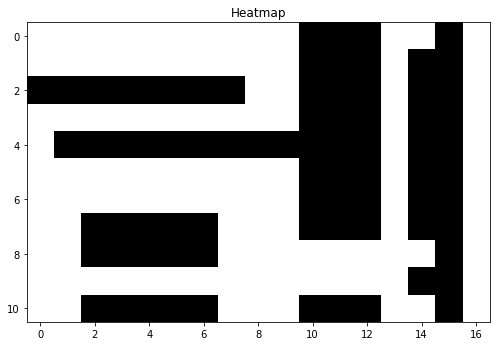

In [ ]:
m = MCLmap([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
            [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
            [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0]])

heatmap(m.m, cmap='binary')

Let's define the motion model as a function `P_motion_sample`.

In [ ]:
def P_motion_sample(kin_state, v, w):
    """Sample from possible kinematic states.
    Returns from a single element distribution (no uncertainity in motion)"""
    pos = kin_state[:2]
    orient = kin_state[2]

    # for simplicity the robot first rotates and then moves
    orient = (orient + w)%4
    for _ in range(orient):
        v = (v[1], -v[0])
    pos = vector_add(pos, v)
    return pos + (orient,)

Define the sensor model as a function `P_sensor`.

In [ ]:
def P_sensor(x, y):
    """Conditional probability for sensor reading"""
    # Need not be exact probability. Can use a scaled value.
    if x == y:
        return 0.8
    elif abs(x - y) <= 2:
        return 0.05
    else:
        return 0

Initializing variables.

In [ ]:
a = {'v': (0, 0), 'w': 0}
z = (2, 4, 1, 6)

Let's run `monte_carlo_localization` with these parameters to find a sample distribution S.

In [ ]:
S = monte_carlo_localization(a, z, 1000, P_motion_sample, P_sensor, m)

Let's plot the values in the sample distribution `S`.

GRID:
  0   0   12     0   143   14     0   0   0   0   0   0   0   0   0   0   0
  0   0    0     0    17   52   201   6   0   0   0   0   0   0   0   0   0
  0   0    0     0     0    0     0   0   0   0   0   0   0   0   0   0   0
  0   0    0     3     5   19     9   3   0   0   0   0   0   0   0   0   0
  0   0    0     0     0    0     0   0   0   0   0   0   0   0   0   0   0
  0   0    6   166     0   21     0   0   0   0   0   0   0   0   0   0   0
  0   0    0     1    11   75     0   0   0   0   0   0   0   0   0   0   0
 73   0    0     0     0    0     0   0   0   1   0   0   0   0   0   0   0
124   0    0     0     0    0     0   1   0   3   0   0   0   0   0   0   0
  0   0    0    14     4   15     1   0   0   0   0   0   0   0   0   0   0
  0   0    0     0     0    0     0   0   0   0   0   0   0   0   0   0   0


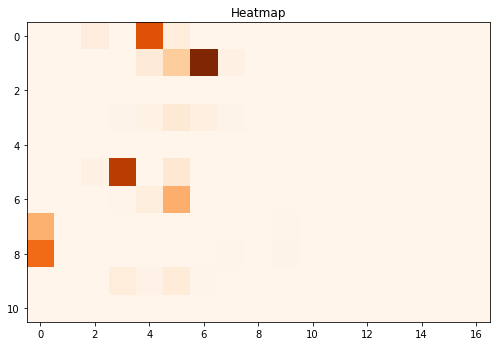

In [ ]:
grid = [[0]*17 for _ in range(11)]
for x, y, _ in S:
    if 0 <= x < 11 and 0 <= y < 17:
        grid[x][y] += 1
print("GRID:")
print_table(grid)
heatmap(grid, cmap='Oranges')

The distribution is highly concentrated at `(5, 3)`, but the robot is not very confident about its position as some other cells also have high probability values.

Let's look at another scenario.

GRID:
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0   1000   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0
0   0   0   0   0   0   0   0      0   0   0   0   0   0   0   0   0


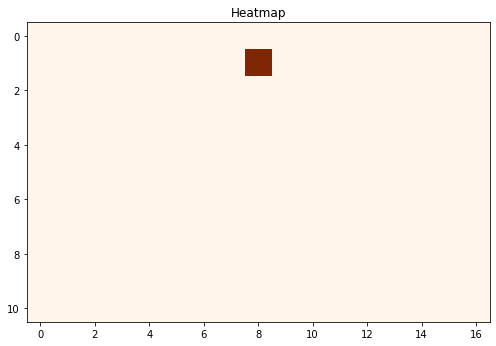

In [ ]:
a = {'v': (0, 1), 'w': 0}
z = (2, 3, 5, 7)
S = monte_carlo_localization(a, z, 1000, P_motion_sample, P_sensor, m, S)
grid = [[0]*17 for _ in range(11)]
for x, y, _ in S:
    if 0 <= x < 11 and 0 <= y < 17:
        grid[x][y] += 1
print("GRID:")
print_table(grid)
heatmap(grid, cmap='Oranges')

In this case, the robot is 99.9% certain that it is at position `(6, 7)`.

## DECISION THEORETIC AGENT

We now move into the domain of probabilistic decision making.
<br>
To make choices between different possible plans in a certain situation in a given environment, an agent must have _preference_ between the possible outcomes of the various plans.
<br>
__Utility theory__ is used to represent and reason with preferences.
The agent prefers states with a higher _utility_.
While constructing multi-agent systems, one major element in the design is the mechanism the agents use for making decisions about which actions to adopt in order to achieve their goals.
What is usually required is a mechanism which ensures that the actions adopted lead to benefits for both individual agents, and the community of which they are part.
The utility of a state is _relative_ to an agent.
<br>
Preferences, as expressed by utilities, are combined with probabilities in the general theory of rational decisions called __decision theory__.
<br>
An agent is said to be _rational_ if and only if it chooses the action that yields the highest expected utility, averaged over all the possible outcomes of the action.

Here we'll see how a decision-theoretic agent is implemented in the module.

In [ ]:
psource(DTAgentProgram)

The `DTAgentProgram` function is pretty self-explanatory.
<br>
It encapsulates a function `program` that takes in an observation or a `percept`, updates its `belief_state` and returns the action that maximizes the `expected_outcome_utility`.

## INFORMATION GATHERING AGENT

Before we discuss what an information gathering agent is, we'll need to know what decision networks are.
For an agent in an environment, a decision network represents information about the agent's current state, its possible actions, the state that will result from the agent's action, and the utility of that state.
Decision networks have three primary kinds of nodes which are:
1. __Chance nodes__: These represent random variables, just like in Bayesian networks.
2. __Decision nodes__: These represent points where the decision-makes has a choice between different actions and the decision maker tries to find the optimal decision at these nodes with regard to the cost, safety and resulting utility.
3. __Utility nodes__: These represent the agent's utility function.
A description of the agent's utility as a function is associated with a utility node.
<br>
<br>
To evaluate a decision network, we do the following:
1. Initialize the evidence variables according to the current state.
2. Calculate posterior probabilities for each possible value of the decision node and calculate the utility resulting from that action.
3. Return the action with the highest utility.
<br>
Let's have a look at the implementation of the `DecisionNetwork` class.

In [ ]:
psource(DecisionNetwork)

The `DecisionNetwork` class inherits from `BayesNet` and has a few extra helper methods.
<br>
`best_action` returns the best action in the network.
<br>
`get_utility` is an abstract method which is supposed to return the utility of a particular action and state in the network.
<br>
`get_expected_utility` computes the expected utility, given an action and evidence.
<br>

Before we proceed, we need to know a few more terms.
<br>
Having __perfect information__ refers to a state of being fully aware of the current state, the cost functions and the outcomes of actions.
This in turn allows an agent to find the exact utility value of each state.
If an agent has perfect information about the environment, maximum expected utility calculations are exact and can be computed with absolute certainty.
<br>
In decision theory, the __value of perfect information__ (VPI) is the price that an agent would be willing to pay in order to gain access to _perfect information_.
VPI calculations are extensively used to calculate expected utilities for nodes in a decision network.
<br>
For a random variable $E_j$ whose value is currently unknown, the value of discovering $E_j$, given current information $e$ must average over all possible values $e_{jk}$ that we might discover for $E_j$, using our _current_ beliefs about its value.
The VPI of $E_j$ is then given by:
<br>
<br>
$$VPI_e(E_j) = \left(\sum_{k}P(E_j=e_{jk}\ |\ e) EU(\alpha_{e_{jk}}\ |\ e, E_j=e_{jk})\right) - EU(\alpha\ |\ e)$$
<br>
VPI is _non-negative_, _non-additive_ and _order-indepentent_.

An information gathering agent is an agent with certain properties that explores decision networks as and when required with heuristics driven by VPI calculations of nodes.
A sensible agent should ask questions in a reasonable order, should avoid asking irrelevant questions, should take into account the importance of each piece of information in relation to its cost and should stop asking questions when that is appropriate.
_VPI_ is used as the primary heuristic to consider all these points in an information gathering agent as the agent ultimately wants to maximize the utility and needs to find the optimal cost and extent of finding the required information.
<br>
As an overview, an information gathering agent works by repeatedly selecting the observations with the highest information value, until the cost of the next observation is greater than its expected benefit.
<br>
The `InformationGatheringAgent` class is an abstract class that inherits from `Agent` and works on the principles discussed above.
Let's have a look.
<br>

In [ ]:
psource(InformationGatheringAgent)

The `cost` method is an abstract method that returns the cost of obtaining the evidence through tests, consultants, questions or any other means.
<br>
The `request` method returns the value of the given random variable as the next percept.
<br>
The `vpi_cost_ratio` method returns a list of VPI divided by cost for each variable in the `variables` list provided to it.
<br>
The `vpi` method calculates the VPI for a given variable
<br>
And finally, the `execute` method executes the general information gathering algorithm, as described in __figure 16.9__ in the book.
<br>
Our agent implements a form of information gathering that is called __myopic__ as the VPI formula is used shortsightedly here.
It calculates the value of information as if only a single evidence variable will be acquired.
This is similar to greedy search, where we do not look at the bigger picture and aim for local optimizations to hopefully reach the global optimum.
This often works well in practice but a myopic agent might hastily take an action when it would have been better to request more variables before taking an action.
A _conditional plan_, on the other hand might work better for some scenarios.
<br>


With this we conclude this notebook.